In [167]:
import string
import numpy as np
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', 100)

In [152]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [84]:
df.shape

(499, 8)

In [106]:
raw_file = '../src/reddit_raw_with_labels.csv'
df = pd.read_csv(raw_file)
df['label'] = df['majority_vote']
df['label'] = df['label'].fillna(df['category_sl'])
df['label'] = df['label'].astype('category')

In [93]:
df.head()

,title,score,num_comments,created_at,body,category_sl,majority_vote,label
0,Live conversation via phone,3,2,8/27/20 16:26,"Hi guys I m quite confused. So i started this month. Since yesterday, i got 3 tests on my dashbo...",live convo,live convo,live convo
1,What's a test with the most steps you've ever got?,6,9,8/27/20 11:19,"I got one with 57 steps a while back, and just did a 48 steps just now. Curious if anyone got an...",bad test,bad test,bad test
2,Preparing for Live Conversation,1,4,8/27/20 10:44,Hi! Iâ€™ve been scheduled for a Live Test on Aug 27 PDT (which is Aug 28 in my country) and itâ€...,live convo,live convo,live convo
3,Mobile Test,0,8,8/27/20 6:50,"Hey yâ€™all...Iâ€™m about to take a test on my mobile device, please do yâ€™all use headphones f...",mobile,mobile,mobile
4,Curious about message,1,7,8/27/20 6:49,&#x200B; [Anyone know what this is?](https://preview.redd.it/jqfjcozz3fj51.png?width=1283&format...,other,other,other


In [228]:
df[df['label'] != 'other']['label'].value_counts(normalize=True)

bad test         0.155807
screeners        0.147309
ratings          0.121813
recorder         0.118980
live convo       0.116147
mobile           0.107649
no test          0.090652
bug              0.082153
payment          0.056657
other company    0.002833
other            0.000000
Name: label, dtype: float64

In [20]:
raw_texts = df['title'].fillna(' ') + ' ' + df['body'].fillna(' ')

In [21]:
raw_texts[0]

'Live conversation via phone Hi guys I m quite confused. So i started this month. Since yesterday, i got 3 tests on my dashboard saying "you are scheduled for a live interview...use zoom on your phone bla bla" Next to it, there is the phone icon yet when i clicked on the thing, i have to take a screener which all 3 times I failed which is disappointing. Anyways, is it normal they use this language "you are scheduled" which i m obviously not since i have to qualify 1st.'

In [23]:
texts = raw_texts.str.lower()

In [24]:
texts[0]

'live conversation via phone hi guys i m quite confused. so i started this month. since yesterday, i got 3 tests on my dashboard saying "you are scheduled for a live interview...use zoom on your phone bla bla" next to it, there is the phone icon yet when i clicked on the thing, i have to take a screener which all 3 times i failed which is disappointing. anyways, is it normal they use this language "you are scheduled" which i m obviously not since i have to qualify 1st.'

In [25]:
PUNCT_TO_REMOVE = string.punctuation.replace('$', '')
PUNCT_TO_REMOVE

'!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

texts = texts.apply(remove_punctuation)
texts[0]

'live conversation via phone hi guys i m quite confused so i started this month since yesterday i got 3 tests on my dashboard saying you are scheduled for a live interviewuse zoom on your phone bla bla next to it there is the phone icon yet when i clicked on the thing i have to take a screener which all 3 times i failed which is disappointing anyways is it normal they use this language you are scheduled which i m obviously not since i have to qualify 1st'

In [27]:
nlp = spacy.load("en_core_web_sm")

In [32]:
texts

0      live conversation via phone hi guys i m quite confused so i started this month since yesterday i...
1      whats a test with the most steps youve ever got i got one with 57 steps a while back and just di...
2      preparing for live conversation hi iâ€™ve been scheduled for a live test on aug 27 pdt which is ...
3      mobile test hey yâ€™alliâ€™m about to take a test on my mobile device please do yâ€™all use head...
4      curious about message x200b anyone know what this ishttpspreviewredditjqfjcozz3fj51pngwidth1283f...
                                                      ...                                                 
494    i now earn more with usertesting than my full time job i live in mexico working in it i earn 410...
495    iphone issue  screener proceeds to next question with unfortunately you didnt qualify window ove...
496    usertesting  test in progress for over 2days i took a reserved test on usertesting three days ag...
497    received usertesting payment f

In [97]:
def get_tokens(text):
    return " ".join([t.lemma_ for t in nlp(text) if not t.is_stop])

tokens = texts.apply(get_tokens)
print(tokens[0])

live conversation phone hi guy m confused start month yesterday get 3 test dashboard say schedule live interviewuse zoom phone bla bla phone icon click thing screener 3 time fail disappointing anyways normal use language schedule m obviously qualify 1st


In [194]:
df['processed_text'] = tokens

In [197]:
def get_train_test(df):
    df_labelled = df[~df['label'].isnull()].sort_values('created_at')
    split_point = int(df_labelled.shape[0] * 0.8)
    df_train = df_labelled[:split_point]
    df_test = df_labelled[split_point:]
    return df_train, df_test

# Note: Excluding 'other' category
df_train, df_test = get_train_test(df[df['label'] != 'other'])
print(df_train.shape, df_test.shape)

(282, 9) (71, 9)


In [207]:
vectorizer = TfidfVectorizer(max_features=10000)

In [208]:
X_train_vec = vectorizer.fit_transform(df_train['processed_text'])
y_train = df_train['label'].values
print(X_train_vec.shape, y_train.shape)

X_test_vec = vectorizer.transform(df_test['processed_text'])
y_test = df_test['label'].values
print(X_test_vec.shape, y_test.shape)

(282, 1789) (282,)
(71, 1789) (71,)


In [219]:
rf = RandomForestClassifier(random_state=100, n_estimators=200, min_samples_split=5, min_samples_leaf=2)
rf.fit(X_train_vec, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=100)

In [220]:
print("Cross Val Score: ", cross_val_score(rf, X_train_vec, y_train, cv=3).mean())
print("Train Score: ", round(rf.score(X_train_vec, y_train), 4))
print("Test Score: ", round(rf.score(X_test_vec, y_test), 4))

/Users/simonthorogood/opt/anaconda3/envs/reddit/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


Cross Val Score:  0.5957446808510639
Train Score:  0.9716
Test Score:  0.6761


In [221]:
rf.classes_

array(['bad test', 'bug', 'live convo', 'mobile', 'no test',
       'other company', 'payment', 'ratings', 'recorder', 'screeners'],
      dtype=object)

In [222]:
rf.predict(X_test_vec[0:5, :])

array(['ratings', 'screeners', 'bad test', 'bad test', 'ratings'],
      dtype=object)

Text(87.0, 0.5, 'true label')

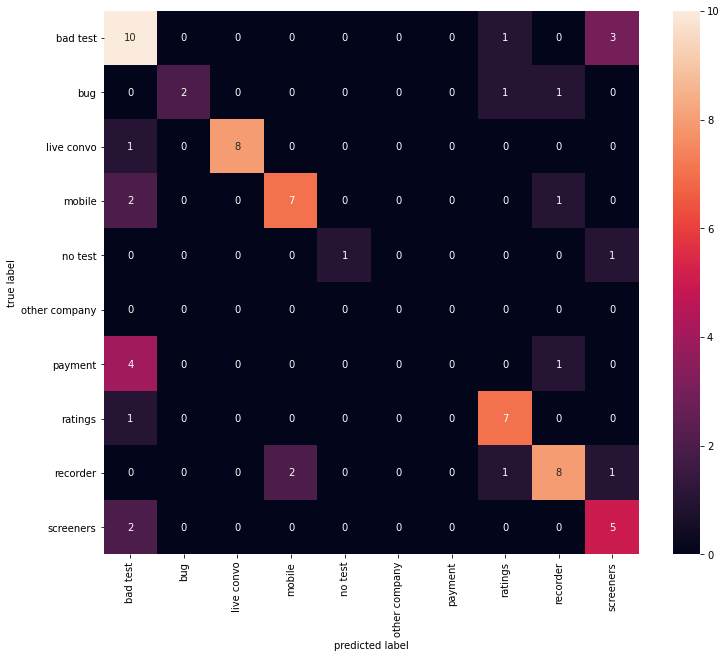

In [223]:
cf = confusion_matrix(y_test, rf.predict(X_test_vec), labels=rf.classes_)
df_cf = pd.DataFrame(cf, columns=rf.classes_, index=rf.classes_)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_cf, ax=ax, annot=True)
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')

In [54]:
doc = nlp("I like painting so I was running down the road to buy some more paints".lower())
print(list([t.text for t in doc]))

['i', 'like', 'painting', 'so', 'i', 'was', 'running', 'down', 'the', 'road', 'to', 'buy', 'some', 'more', 'paints']


In [58]:
print(list([t.pos_ for t in doc]))

['PRON', 'VERB', 'VERB', 'ADV', 'PRON', 'AUX', 'VERB', 'ADP', 'DET', 'NOUN', 'PART', 'VERB', 'DET', 'ADJ', 'NOUN']


In [55]:
print(list([t.text for t in doc if not t.is_stop]))

['like', 'painting', 'running', 'road', 'buy', 'paints']


In [53]:
print(list([t.lemma_ for t in doc if not t.is_stop]))

['like', 'paint', 'run', 'road', 'buy', 'paint']
